In [1]:
from utils_cv import *

%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import collections
import time
from skimage import io
from skimage.feature import canny
from skimage.transform import rescale
from skimage.morphology import dilation, disk

from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils

import time

%matplotlib inline

from IPython import display

from scipy.ndimage import distance_transform_edt

ДОБАВИТЬ ПРОВЕРКУ ЧТО КОНТУР НАЙДЕН И ВМЕНЯЕМ, ИНАЧЕ НЕ ВЫДАВАТЬ НИЧЕГО 
ДОБАВИТЬ ВОЗМОЖНСТЬ С РАЗНЫХ РАКУРСОВ РАССМАТРИВАТЬ 


In [3]:
files = np.array(os.listdir('data/'))
index = ['.jpg' in i for i in files]
paths = ['data/'+i for i in files[index]]

In [4]:
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in read_images(paths)]

In [5]:
grayscale_images = [cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) for i in range(len(images))]

In [6]:
len(images)

5

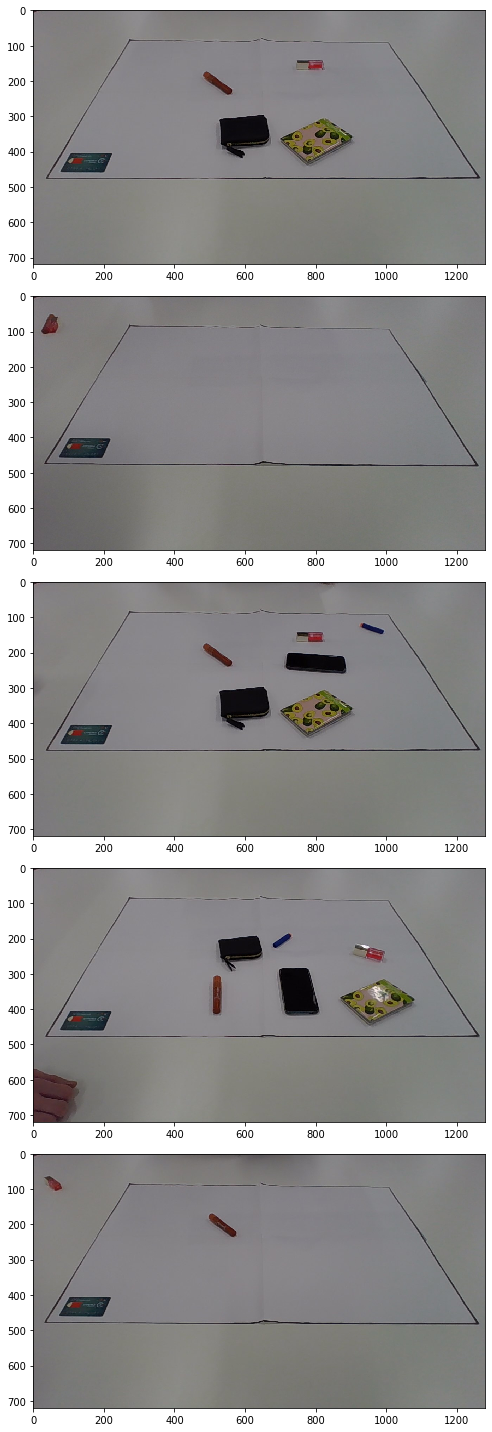

In [7]:
print_images(images, 5, 1)

In [303]:
def normalize_image(image, image_colored, rescale_param = 0.5):
    image_scaled = rescale(image, rescale_param)
    edges = canny(image_scaled)
    
    selem = disk(1)
    edges = dilation(edges, selem)
    
    edges = (edges).astype(np.uint8)
    img, ext_contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(ext_contours, key=cv2.contourArea)    
    contour = contour.squeeze()
    
    epsilon = 0.05 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()
    corners = (perspective.order_points(corners))
    corners = corners/rescale_param
    
    size_square = min(image_scaled.shape)
    tform = ProjectiveTransform()
    tform.estimate(np.array([[0,0], [1020,0], [1020,720], [0, 720]]), corners)
    image_warped = warp(image_colored, tform)[:720,:1020]

    data = image_warped.astype('float64') / np.max(image_warped)
    data = 255 * data
    img = data.astype('uint8')
    img = adjusting_brightness(img[30:-5, 15:-15], a = 1.5, b = 3)
    return img

In [304]:
n = 3
image_redone = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)

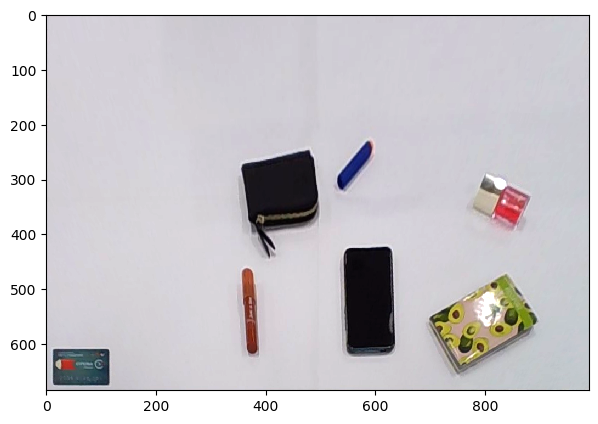

In [305]:
show(image_redone)

In [220]:
image = cv2.cvtColor(normalize_image(grayscale_images[n], images[n], rescale_param = 0.6), cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(image, (7, 7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)
 
img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                cv2.RETR_EXTERNAL,
                                                cv2.CHAIN_APPROX_SIMPLE)

(cnts, _) = contours.sort_contours(ext_contours)
cnts = [cnt[:, 0] for cnt in cnts]
pixelsPerMetric = None

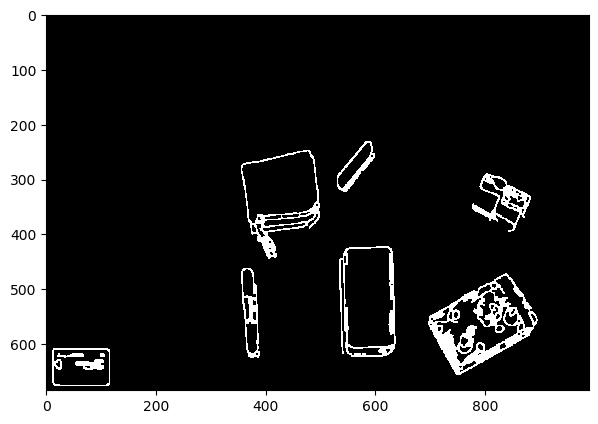

In [221]:
show(img)

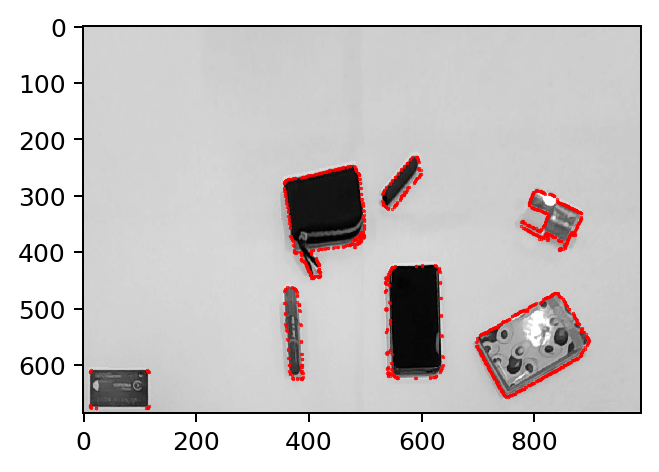

In [222]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(image, cmap = 'gray')
for i in range(len(cnts)):
    plt.scatter(cnts[i][:, 0], cnts[i][:, 1], c = 'r', s = 0.1)

In [226]:
result = image.copy()

In [301]:
def middle(x, y):
    return ((x[0]+y[0])/2, (x[1]+y[1])/2)

result = image_redone.copy()
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    
    box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
    box = perspective.order_points(box).astype('int32')
    cv2.drawContours(result, [box], -1, (255, 0, 116), 2)
        
    top_left, top_right, bottom_right, bottom_left = box
    
    top_x, top_y = middle(top_left, top_right)
    bottom_x, bottom_y = middle(bottom_left, bottom_right)
    left_x, left_y = middle(top_left, bottom_left)
    right_x, right_y = middle(top_right, bottom_right)

    distance_1 = dist.euclidean((top_x, top_y), (bottom_x, bottom_y))
    distance_2 = dist.euclidean((left_x, left_y), (right_x, right_y))
        
    dimA = distance_2 * 0.076
    dimB = distance_1 * 0.076
    
    
    cv2.circle(result, (int(top_x), int(top_y)), 5, (255, 0, 0), -1)
    cv2.putText(result, "{:.1f} cm".format(dimA),
        (int(top_x - 3), int(top_y - 3)), 0, 0.65, (255, 255, 255), 2)
    
    cv2.circle(result, (int(right_x), int(right_y)), 5, (255, 0, 0), -1)
    cv2.putText(result, "{:.1f} cm".format(dimB),
        (int(right_x + 3), int(right_y)), 0, 0.65, (255, 255, 255), 2)


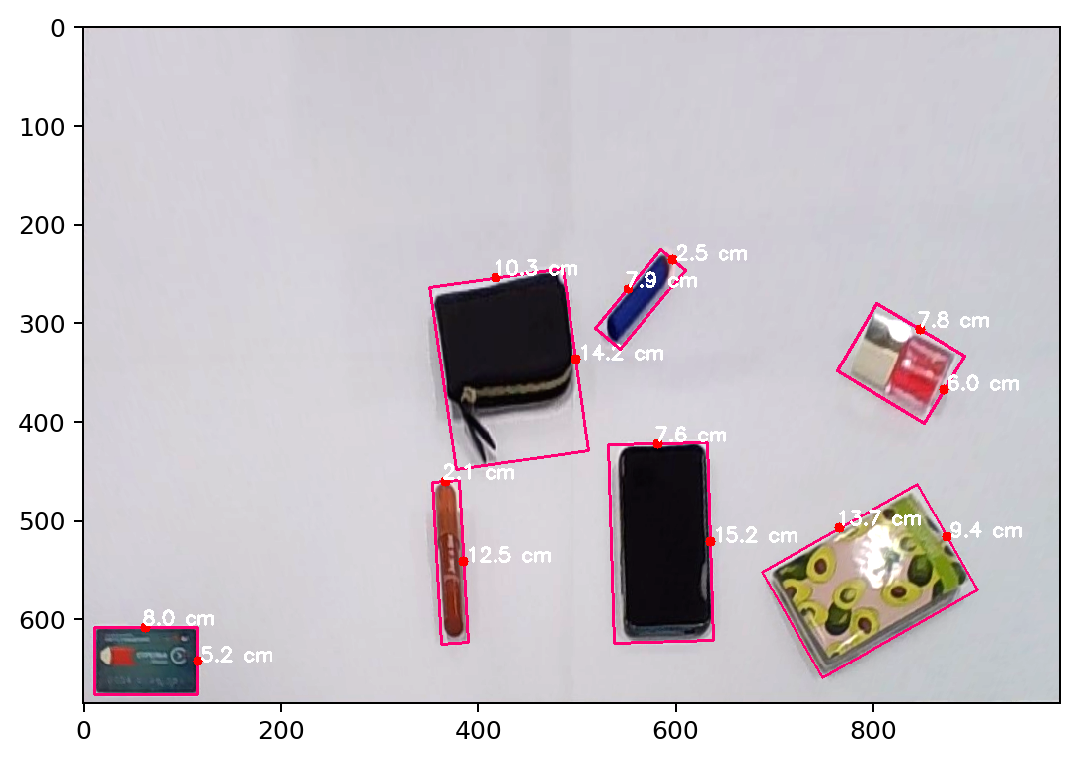

In [322]:
plt.figure(figsize = (7, 7), dpi = 180)
plt.imshow(result)
plt.show()

In [320]:
def pipeline(original):
    def middle(x, y):
        return ((x[0]+y[0])/2, (x[1]+y[1])/2)
    
    image_redone = normalize_image(cv2.cvtColor(original, cv2.COLOR_RGB2GRAY),
                                   original,
                                   rescale_param = 0.6)
    
    gray = cv2.cvtColor(image_redone,
                         cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)

    img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                    cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)

    (cnts, _) = contours.sort_contours(ext_contours)
    cnts = [cnt[:, 0] for cnt in cnts]
    pixelsPerMetric = None

    result = image_redone.copy()
    for c in cnts:
        if cv2.contourArea(c) < 100:
            continue

        box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
        box = perspective.order_points(box).astype('int32')
        cv2.drawContours(result, [box], -1, (255, 0, 116), 2)

        top_left, top_right, bottom_right, bottom_left = box

        top_x, top_y = middle(top_left, top_right)
        bottom_x, bottom_y = middle(bottom_left, bottom_right)
        left_x, left_y = middle(top_left, bottom_left)
        right_x, right_y = middle(top_right, bottom_right)

        distance_1 = dist.euclidean((top_x, top_y), (bottom_x, bottom_y))
        distance_2 = dist.euclidean((left_x, left_y), (right_x, right_y))

        dimA = distance_2 * 0.076
        dimB = distance_1 * 0.076


        cv2.circle(result, (int(top_x), int(top_y)), 5, (255, 0, 0), -1)
        cv2.putText(result, "{:.1f} cm".format(dimA),
            (int(top_x - 10), int(top_y - 10)), 0, 0.65, (255, 0, 0), 2)

        cv2.circle(result, (int(right_x), int(right_y)), 5, (255, 0, 0), -1)
        cv2.putText(result, "{:.1f} cm".format(dimB),
            (int(right_x + 5), int(right_y)), 0, 0.65, (255, 0, 0), 2)
        
    return result

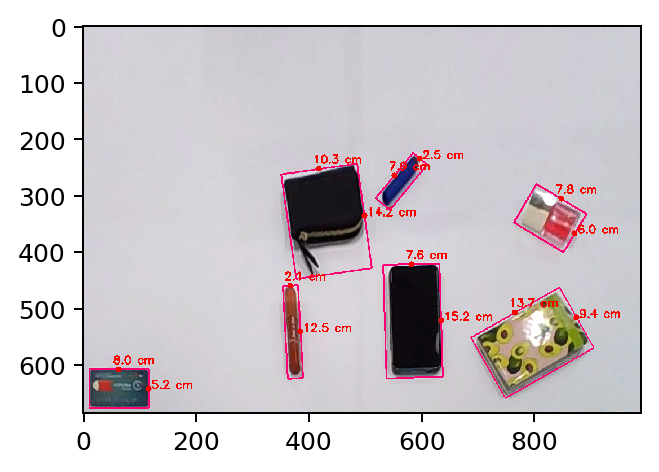

In [321]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(pipeline(images[3]))
plt.show()

In [5]:
# but this works somehow

video_capture = cv2.VideoCapture(0)
frames = []
# while video_capture.isOpened():
for i in range(10):
    ret, frame = video_capture.read()
    frames.append(frame)
    if ret:
        #cv2.imshow('Video', frame)
        display.clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), cmap = 'gray')
        plt.show()
        time.sleep(0.002)
        
        k = cv2.waitKey(33) & 0xff
        if  k == 27: 
            break
    else:
        break
video_capture.release()
# cv2.destroyAllWindows()